In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES" ] = '0'

In [2]:
import pickle
import scipy.io as sio
import numpy as np 
import matplotlib.pyplot as plt
from copy import deepcopy
from scipy.optimize import leastsq
import random
import shutil
import pyswarms as ps
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
import torch.utils.data as Data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

Duplicate key in file PosixPath('/home/user/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc'), line 759 ('font.family         : sans-serif')
Duplicate key in file PosixPath('/home/user/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc'), line 760 ('font.sans-serif         : SimHei')
Duplicate key in file PosixPath('/home/user/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc'), line 761 ('axes.unicode_minus  : False')


In [3]:
'''Loading data'''

Voltage = pickle.load(open('fea_lab.pkl','rb'))
SOH = pickle.load(open('label_lab.pkl','rb'))

label5 = SOH[5][:np.where(SOH[5]/2900<0.8)[0][0], :]/2900 # Divide nominal capacity
label6 = SOH[6][:np.where(SOH[6]/2900<0.8)[0][0], :]/2900

data5 = Voltage[5][:np.where(SOH[5]/2900<0.8)[0][0], :]
data6 = Voltage[6][:np.where(SOH[6]/2900<0.8)[0][0], :]

In [4]:
prior_len = 100   
train_data = np.expand_dims(data5, axis=1)
train_data = np.expand_dims(train_data, axis=3)
train_label = label5

test_data = np.expand_dims(data6, axis=1)
test_data = np.expand_dims(test_data, axis=3)
test_label = label6

train_data_mmd = train_data[:prior_len, :, :]  # The first 100 cycles 
test_data_mmd = test_data[:prior_len, :, :]    # The first 100 cycles 

In [5]:
'''Create samples''' 
train_data_o = np.repeat(train_data, 2, axis=1)  # The repeated all source data   m x 2 x 1000 x 1
test_data_o = np.repeat(test_data, 2, axis=1)    # The repeated all target data   n x 2 x 1000 x 1

train_label_o = deepcopy(train_label)            # The source label   m x 1          
test_label_o = deepcopy(test_label)              # The target label   n x 1

train_data_c_mmd = train_data[:prior_len]        # The first 100 cycles of source data    100 x 1 x 1000 x 1
test_data_c_mmd = test_data[:prior_len]          # The first 100 cycles of target data    100 x 1 x 1000 x 1

train_data_o_mmd = np.repeat(train_data[:prior_len], 2, axis=1)  # The first 100 cycles of repeated source data   100 x 2 x 1000 x 1
test_data_o_mmd = np.repeat(test_data[:prior_len], 2, axis=1)    # The first 100 cycles of repeated target data   100 x 2 x 1000 x 1

train_label_c = train_label[:prior_len]          # The first 100 cycles of source label  100x1
test_label_c = test_label[:prior_len]            # The first 100 cycles of target label  100x1


In [6]:
print (train_data.shape, train_label_o.shape)
print (test_data.shape, test_label_o.shape)
print (train_data_o.shape, test_data_o.shape)
print (train_data_c_mmd.shape, test_data_c_mmd.shape)
print (train_data_o_mmd.shape, test_data_o_mmd.shape)
print (train_label_c.shape, test_label_c.shape)

(419, 1, 1000, 1) (419, 1)
(603, 1, 1000, 1) (603, 1)
(419, 2, 1000, 1) (603, 2, 1000, 1)
(100, 1, 1000, 1) (100, 1, 1000, 1)
(100, 2, 1000, 1) (100, 2, 1000, 1)
(100, 1) (100, 1)


In [7]:
'''Creat tensors for training, testing, validation and mmd_data''' 

x_train_o_s, y_train_o_s = deepcopy(train_data_o), deepcopy(train_label_o)    # The repeated all source data/labels   m x 2 x 1000 x 1/ m x 1 
x_train_o_t, y_train_o_t = deepcopy(test_data_o_mmd), deepcopy(test_label_c)  # The first 100 cycles of repeated target data/label    100 x 2 x 1000 x 1/100 x 1

x_train_o_s = torch.FloatTensor(x_train_o_s).cuda()            # The repeated all source data    m x 2 x 1000 x 1
y_train_o_s = torch.FloatTensor(y_train_o_s).cuda()            # The repeated all source label   m x 1

x_train_o_t = torch.FloatTensor(x_train_o_t).cuda()            # The first 100 cycles of repeated target data    100 x 2 x 1000 x 1
y_train_o_t = torch.FloatTensor(y_train_o_t).cuda()            # The first 100 cycles of repeated target label   100 x 1

x_val_o = x_train_o_t                                          # Validation data:  The first 100 cycles of repeated target data    100 x 2 x 1000 x 1
y_val_o = y_train_o_t                                          # Validation label: The first 100 cycles of repeated target label   100 x 1

test_data_o = torch.FloatTensor(test_data_o).cuda()            # The repeated all target data   n x 2 x 1000 x 1
test_label_o = torch.FloatTensor(test_label_o).cuda()          # The all target label   n x 1

train_data_o_mmd = torch.FloatTensor(train_data_o_mmd).cuda()  # The first 100 cycles of repeated source data   100 x 2 x 1000 x 1 
test_data_o_mmd = torch.FloatTensor(test_data_o_mmd).cuda()    # The first 100 cycles of repeated target data   100 x 2 x 1000 x 1

train_data_c_mmd = torch.FloatTensor(train_data_c_mmd).cuda()  # The first 100 cycles of source data    100 x 1 x 1000 x 1
test_data_c_mmd = torch.FloatTensor(test_data_c_mmd).cuda()    # The first 100 cycles of target data    100 x 1 x 1000 x 1

train_label_c = torch.FloatTensor(train_label_c).cuda()        # The first 100 cycles of source label   100 x 1 
test_label_c = torch.FloatTensor(test_label_c).cuda()          # The first 100 cycles of target label   100 x 1


In [8]:
'''Create MMD computation'''
def compute_kernel(x, y, sigma):
    x_size = x.size(0)
    y_size = y.size(0)
    dim = x.size(1)
    x = x.unsqueeze(1) # (x_size, 1, dim)
    y = y.unsqueeze(0) # (1, y_size, dim)
    tiled_x = x.expand(x_size, y_size, dim)
    tiled_y = y.expand(x_size, y_size, dim)
    kernel_input = (tiled_x - tiled_y).pow(2).sum(2)/float(dim)
    return torch.exp(-kernel_input/sigma) # (x_size, y_size)

def mmd_loss(x, y, sigma):
    x_kernel = compute_kernel(x, x, sigma)
    y_kernel = compute_kernel(y, y, sigma)
    xy_kernel = compute_kernel(x, y, sigma)
    mmd = x_kernel.mean() + y_kernel.mean() - 2*xy_kernel.mean()
    return mmd

In [9]:
'''Create Model structrue'''
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.mapping = torch.nn.Linear(1,1000)       
        self.layer1 = torch.nn.Sequential(
                        torch.nn.Conv2d(2, 8, kernel_size=(20,1), stride=(2,1)),
                        torch.nn.LeakyReLU(inplace=True))
        self.layer2 = torch.nn.Sequential(
                        torch.nn.Conv2d(8, 16, kernel_size=(20,1), stride=(2,1)),
                        torch.nn.LeakyReLU(inplace=True))
        self.layer3 = torch.nn.Sequential(
                        torch.nn.Conv2d(16, 32, kernel_size=(2,1), stride=1),
                        torch.nn.LeakyReLU(inplace=True))
        self.fc1 = torch.nn.Sequential(torch.nn.Linear(7520,256),
                                       torch.nn.LeakyReLU(inplace=True))
        self.fc2 = torch.nn.Linear(256,1)       
    
    def forward(self, x_src_o, x_tar_o, x_src_o_mmd, x_tar_o_mmd, x_src_o_label, x_tar_o_label, x_src_c_mmd, x_tar_c_mmd, sigma):
        '''x_src_o: Repeated all source data   m x 2 x 100 x 1; 
           x_tar_o: The first 100 cycles of repeated source data  100 x 2 x 1000 x 1; 
           
           Group1: 
           x_src_o_mmd: The first 100 cycles of repeated source data  100 x 2 x 1000 x 1; 
           x_tar_o_mmd: The first 100 cycles of repeated target data  100 x 2 x 1000 x 1; 
           
           Group3 (before embedding): 
           x_src_o_label: The first 100 cycles of source label  100 x 1; 
           x_tar_o_label: The first 100 cycles of target label  100 x 1;    
           
           Group2 (before conditioning with label): 
           x_src_c_mmd: The first 100 cycles of source data  100 x 1 x 1000 x 1; 
           x_tar_c_mmd: The first 100 cycles of target data  100 x 1 x 1000 x 1;  
           
           sigma : hyperparameters
        '''
    
        loss=0
        x_tar0 = self.layer1(x_tar_o_mmd)           # Input: x_tar_o_mmd 
        x_tar1 = self.layer2(x_tar0)
        x_tar2 = self.layer3(x_tar1)    
        x_tar3 = x_tar2.view(x_tar2.size(0), -1)
        x_tar4 = self.fc1(x_tar3)                   # Extracted deep features of the first 100 cycles of repeated target data: 100x256
        
        x_src0 = self.layer1(x_src_o)               # Input: x_src_o 
        x_src1 = self.layer2(x_src0)
        x_src2 = self.layer3(x_src1)
        x_src3 = x_src2.view(x_src2.size(0), -1)
        x_src4 = self.fc1(x_src3)                   # Extracted deep features of repeated all source data: 603x256
        
        x_tar00 = self.layer1(x_tar_o)              # Input: x_tar_o
        x_tar01 = self.layer2(x_tar00)
        x_tar02 = self.layer3(x_tar01)
        x_tar03 = x_tar02.view(x_tar02.size(0), -1) 
        x_tar04 = self.fc1(x_tar03)                 # Extracted deep features of repeated target data: 100x256 
        
        x_src01 = self.layer1(x_src_o_mmd)          # Input: x_src_o_mmd
        x_src11 = self.layer2(x_src01)
        x_src22 = self.layer3(x_src11)
        x_src33 = x_src22.view(x_src22.size(0), -1)
        x_src44 = self.fc1(x_src33)                  # Extracted deep features of repeated source data: 100x256 
        
        src_mapping1 = self.mapping(x_src_o_label)   # Input: x_src_o_label  For embedding
        src_mapping2 = src_mapping1.view(src_mapping1.size(0), 1, 1000, 1) # After embedding: 100x1x1000x1
        src_mapping3 = src_mapping2.repeat(1, 2, 1, 1)  # After repeating: 100x2x1000x1
        
        src_cat = torch.cat((x_src_c_mmd, src_mapping2), 1)  # contentate The first 100 cycles of source data and embedded labels   100x 2 x1000x1
        
        tar_mapping1 = self.mapping(x_tar_o_label)   # Input: x_tar_o_label  For embedding      
        tar_mapping2 = tar_mapping1.view(tar_mapping1.size(0), 1, 1000, 1)  # After embedding: 100x1x1000x1
        tar_mapping3 = tar_mapping2.repeat(1, 2, 1, 1)  # After repeating: 100x2x1000x1
        
        tar_cat = torch.cat((x_tar_c_mmd, tar_mapping2), 1)   # contentate The first 100 cycles of target data and embedded labels   100x 2 x1000x1   
        
        x_src_data_c_01 = self.layer1(src_cat)            # Input (Conditional source data): src_cat  100x2x1000x1
        x_src_data_c_02 = self.layer2(x_src_data_c_01)
        x_src_data_c_03 = self.layer3(x_src_data_c_02)
        x_src_data_c_04 = x_src_data_c_03.view(x_src_data_c_03.size(0), -1)
        x_src_data_c_05 = self.fc1(x_src_data_c_04)        # Extracted deep features of conditional source data: 100x256
        
        x_tar_data_c_01 = self.layer1(tar_cat)          # Input (Conditional target data): tar_cat  100x2x1000x1
        x_tar_data_c_02 = self.layer2(x_tar_data_c_01)
        x_tar_data_c_03 = self.layer3(x_tar_data_c_02)
        x_tar_data_c_04 = x_tar_data_c_03.view(x_tar_data_c_03.size(0), -1)
        x_tar_data_c_05 = self.fc1(x_tar_data_c_04)     # Extracted deep features of conditional target data: 100x256
        
        x_src_label_c_01 = self.layer1(src_mapping3)    # Input: src_mapping3 (the repeated source labels) 100x2x1000x1
        x_src_label_c_02 = self.layer2(x_src_label_c_01)
        x_src_label_c_03 = self.layer3(x_src_label_c_02)
        x_src_label_c_04 = x_src_label_c_03.view(x_src_label_c_03.size(0), -1)
        x_src_label_c_05 = self.fc1(x_src_label_c_04)   # Extracted deep features of repeated source labels: 100x256
        
        x_tar_label_c_01 = self.layer1(tar_mapping3)     # Input: tar_mapping3 (the repeated target labels) 100x2x1000x1
        x_tar_label_c_02 = self.layer2(x_tar_label_c_01)
        x_tar_label_c_03 = self.layer3(x_tar_label_c_02)
        x_tar_label_c_04 = x_tar_label_c_03.view(x_tar_label_c_03.size(0), -1)
        x_tar_label_c_05 = self.fc1(x_tar_label_c_04)   # Extracted deep features of repeated target labels: 100x256     
        
        if self.training == True: 
            loss1 = mmd_loss(x_src44, x_tar4, sigma)                   # p(x) mmd loss
            loss2 = mmd_loss(x_src_data_c_05, x_tar_data_c_05, sigma)  # p(x|y) mmd loss
            loss3 = mmd_loss(x_src_label_c_05, x_tar_label_c_05, sigma)# p(y) mmd loss
            loss = loss + loss1 + loss2 + loss3    # Add mmd loss 
        x_src5 = torch.sigmoid(self.fc2(x_src4))   # Labeled source output 
        x_tar05 = torch.sigmoid(self.fc2(x_tar04)) # Labeled target output        
        return x_src5, x_tar05, loss

In [10]:
'''Create PSO objective function'''
def pso_func(x, net_para, opt_para, model, opt):
    n_particles = x.shape[0] 
    f=[]
    for i in range(n_particles):
        model.load_state_dict(net_para)
        opt.load_state_dict(opt_para)
        train_predict_s, train_predict_t, loss_unspv = model(x_train_o_s, x_train_o_t, train_data_o_mmd, test_data_o_mmd, train_label_c, test_label_c, train_data_c_mmd, test_data_c_mmd, sigma=x[i,0])
        loss_spv_s = loss_func(train_predict_s, y_train_o_s)
        loss_spv_t = loss_func(train_predict_t, y_train_o_t)
        loss_all = loss_spv_s + x[i,1]*loss_spv_t + x[i,2]*loss_unspv
        opt.zero_grad()
        loss_all.backward()
        opt.step()
        
        train_predict_s_new, tar_predict_t_new, loss_unspv_new = model(x_train_o_s, x_train_o_t, train_data_o_mmd, test_data_o_mmd, train_label_c, test_label_c, train_data_c_mmd, test_data_c_mmd, sigma=x[i,0])
        loss_spv_s_new = loss_func(train_predict_s_new, y_train_o_s)
        loss_spv_t_new = loss_func(tar_predict_t_new, y_train_o_t)       
        loss_all_new = loss_spv_s_new + x[i,1]*loss_spv_t_new + x[i,2]*loss_unspv_new
        
        f.append(loss_all_new.cpu().detach().numpy())
    return np.array(f)

In [11]:
'''----------Reproducible---------'''
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
'''-------------------------------'''

'''Define Model, optimizer and loss function'''
net = Net().cuda()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.99)
loss_func = torch.nn.MSELoss() 
'''-------------------------------------------'''

'''--------PSO parameters---------'''
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}
constraints = (np.array([0, 2, 0]), np.array([100, 20, 100]))
optimizer_pso = ps.single.GlobalBestPSO(n_particles=20, dimensions=3, options=options, bounds=constraints)
'''-------------------------------'''

'-------------------------------'

In [ ]:
POS = []
COST = []
indx = []
min_loss = 1000
interval = 50
for t in range(6000):
    net.train()
    optimizer.zero_grad() 
    
    if (t%interval==0):
        parameter_save = deepcopy(net.state_dict())  
        optimizer_save = deepcopy(optimizer.state_dict())
        cost, pos = optimizer_pso.optimize(pso_func, iters = 100, net_para = parameter_save, opt_para = optimizer_save, model = net, opt = optimizer)
        net.load_state_dict(parameter_save)
        optimizer.load_state_dict(optimizer_save)
        
    POS.append(pos)
    COST.append(cost)
    
    train_predict_s, train_predict_t, trainmmdlosses = net(x_train_o_s, x_train_o_t, train_data_o_mmd, test_data_o_mmd, train_label_c, test_label_c, train_data_c_mmd, test_data_c_mmd, sigma=pos[0])
    train_loss_s = loss_func(train_predict_s, y_train_o_s)
    train_loss_t = loss_func(train_predict_t, y_train_o_t)   
    
    loss = train_loss_s + pos[1]*train_loss_t + pos[2]*trainmmdlosses

    loss.backward()             
    optimizer.step()   

    net.eval()
    with torch.no_grad():
        val_prediction1, val_prediction2, valmmdloss = net(x_val_o, x_train_o_t, train_data_o_mmd, test_data_o_mmd, train_label_c, test_label_c, train_data_c_mmd, test_data_c_mmd, sigma=pos[0])
        val_loss = loss_func(val_prediction1, y_val_o)

    if val_loss.cpu().data.numpy() < min_loss:
        min_loss = val_loss.cpu().data.numpy()
        print("save model")
        torch.save(net.state_dict(),'best_model.pkl')  
        indx.append(t)
    print ('Step = %d' % t, 'loss:',loss.cpu().data.numpy())

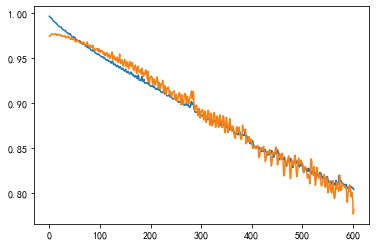

In [15]:
'''Loading the trained model'''
net = Net().cuda()
pos = sio.loadmat('hyperparameters_save.mat')['Hyperparameters'][-1,:] 
net.load_state_dict(torch.load('model_save.pkl'))
net.eval()
with torch.no_grad():
    test_prediction, _, s = net(test_data_o, x_train_o_t, train_data_o_mmd, test_data_o_mmd, train_label_c, test_label_c, train_data_c_mmd, test_data_c_mmd, sigma=pos[0])
    test_loss = loss_func(test_prediction, test_label_o)
plt.plot(test_label_o.cpu())
plt.plot(test_prediction.cpu())
plt.show()